In [1]:
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
from Models.selective_sequential import *
from Loss.triplet_regularized import *
from session import *
from LR_Schedule.cyclical import Cyclical
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
import Datasets.ImageData as ImageData
from Transforms.ImageTransforms import *
import util
from session import LossMeter, EvalModel
from Layers.flatten import Flatten
from torch.utils.tensorboard import SummaryWriter

In [2]:
%load_ext autoreload
%autoreload 2

torch.cuda.set_device(0); torch.backends.cudnn.benchmark=True;

/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/torch/cuda/__init__.py:135: UserWarning: 
    Found GPU0 GeForce GTX 770 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

fulltrainset = datasets.MNIST('/media/drake/MX500/Datasets/mnist/train', download=True, train=True, transform=transform)
trainset = torch.utils.data.dataset.Subset(fulltrainset, np.arange(1000))

fullvalset = datasets.MNIST('/media/drake/MX500/Datasets/mnist/test', download=True, train=False, transform=transform)
valset = torch.utils.data.dataset.Subset(fullvalset, np.arange(1000))

trainloader = torch.utils.data.DataLoader(fulltrainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(fullvalset, batch_size=64, shuffle=False)

In [4]:
select = ['act1', 'out']
model = SelectiveSequential(
    select,
    {'conv64': nn.Conv2d(1, 64, kernel_size=5, padding=2),
     'act64': nn.ReLU(True),
     
     'max1': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv192': nn.Conv2d(64, 192, kernel_size=5, padding=2),
     'act192': nn.ReLU(True),
    
     'max2': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv384': nn.Conv2d(192, 384, kernel_size=3, padding=1),
     'act384': nn.ReLU(True),
     
     'conv256a': nn.Conv2d(384, 256, kernel_size=3, padding=1),
     'act256a': nn.ReLU(True),
     
     'conv256b': nn.Conv2d(256, 256, kernel_size=3, padding=1),
     'act256b': nn.ReLU(True),
     
     'max3': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'flatten': Flatten(),
     'fc1': nn.Linear(3 * 3 * 256, 512),
     'act1': nn.ReLU(True),
     'fc2': nn.Linear(512, 512),
     'act2': nn.ReLU(True),
     'out': nn.Linear(512, 10)})

In [5]:
criterion = TripletRegularizedMultiMarginLoss(0, .5)
sess = Session(model, criterion, optim.Adam, 1e-4)

In [6]:
validator = EmbeddingSpaceValidator(valloader, len(select)-1, CustomOneHotAccuracy)
lr_scheduler = CosAnneal(len(trainloader) * 10, T_mult=1, lr_min=1e-6)
schedule = TrainingSchedule(trainloader, [lr_scheduler, validator])

In [7]:
sess.train(schedule, 10)

Validating: 100%|██████████| 157/157 [00:04<00:00, 32.12it/s]


val accuracy:  0.9741 
train loss:  0.0143  train BCE :  0.4342 
valid loss:  0.0091  valid BCE :  0.2385


Validating: 100%|██████████| 157/157 [00:04<00:00, 34.16it/s]


val accuracy:  0.9821 
train loss:  0.0068  train BCE :  0.1621 
valid loss:  0.0057  valid BCE :  0.1385


Validating: 100%|██████████| 157/157 [00:04<00:00, 33.90it/s]


val accuracy:  0.9855 
train loss:  0.0042  train BCE :  0.1147 
valid loss:  0.0047  valid BCE :  0.0967


KeyboardInterrupt: 

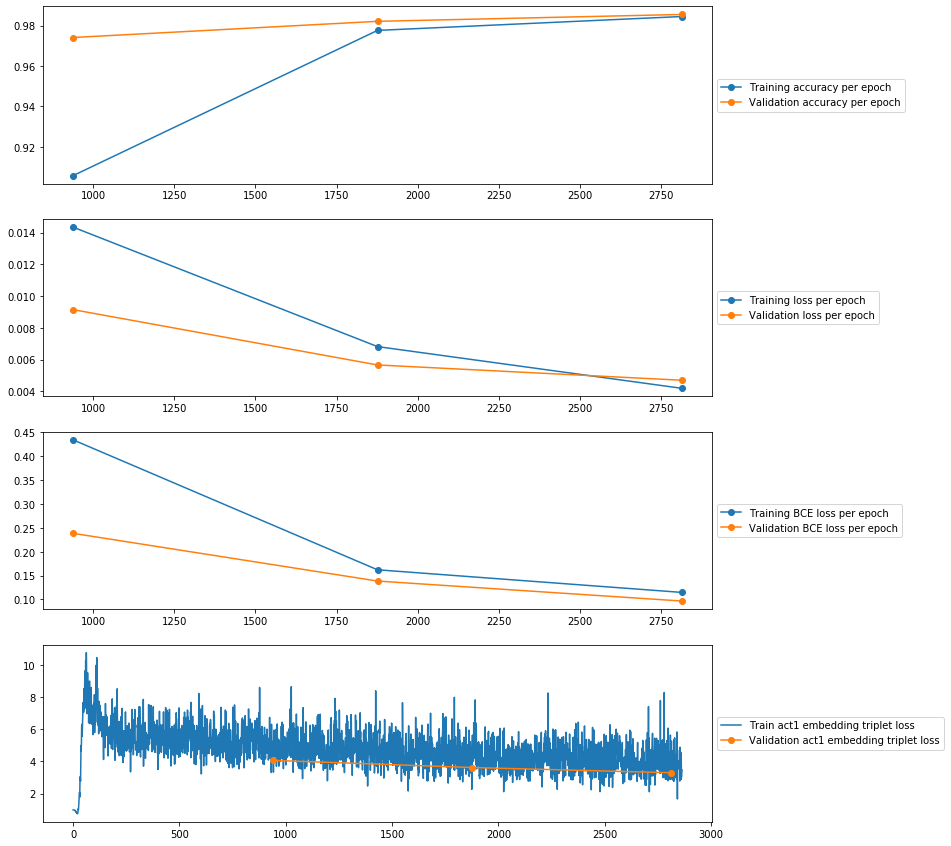

In [8]:
validator.plot()

In [11]:
select = ['act1', 'out']
model2 = SelectiveSequential(
    select,
    {'conv64': nn.Conv2d(1, 64, kernel_size=5, padding=2),
     'act64': nn.ReLU(True),
     
     'max1': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv192': nn.Conv2d(64, 192, kernel_size=5, padding=2),
     'act192': nn.ReLU(True),
    
     'max2': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv384': nn.Conv2d(192, 384, kernel_size=3, padding=1),
     'act384': nn.ReLU(True),
     
     'conv256a': nn.Conv2d(384, 256, kernel_size=3, padding=1),
     'act256a': nn.ReLU(True),
     
     'conv256b': nn.Conv2d(256, 256, kernel_size=3, padding=1),
     'act256b': nn.ReLU(True),
     
     'max3': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'flatten': Flatten(),
     'fc1': nn.Linear(3 * 3 * 256, 512),
     'act1': nn.ReLU(True),
     'fc2': nn.Linear(512, 512),
     'act2': nn.ReLU(True),
     'out': nn.Linear(512, 10)})

In [12]:
criterion = TripletRegularizedMultiMarginLoss(.1, .5)
sess = Session(model2, criterion, optim.Adam, 1e-4)

In [13]:
validator2 = EmbeddingSpaceValidator(valloader, len(select)-1, CustomOneHotAccuracy)
lr_scheduler = CosAnneal(len(trainloader) * 10, T_mult=1, lr_min=1e-6)
schedule = TrainingSchedule(trainloader, [lr_scheduler, validator2])

In [14]:
sess.train(schedule, 10)

Validating: 100%|██████████| 157/157 [00:05<00:00, 31.02it/s]


val accuracy:  0.99 
train loss:  0.0195  train BCE :  0.8332 
valid loss:  0.0137  valid BCE :  0.4789


Validating: 100%|██████████| 157/157 [00:04<00:00, 32.11it/s]


val accuracy:  0.9894 
train loss:  0.0118  train BCE :  0.4593 
valid loss:  0.0109  valid BCE :  0.4162


Validating: 100%|██████████| 157/157 [00:04<00:00, 32.61it/s]


val accuracy:  0.9901 
train loss:  0.0082  train BCE :  0.3624 
valid loss:  0.0086  valid BCE :  0.3354


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.72it/s]


val accuracy:  0.9942 
train loss:  0.005  train BCE :  0.2797 
valid loss:  0.0058  valid BCE :  0.233


Validating: 100%|██████████| 157/157 [00:04<00:00, 32.62it/s]


val accuracy:  0.9943 
train loss:  0.0038  train BCE :  0.228 
valid loss:  0.0051  valid BCE :  0.1848


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.94it/s]


val accuracy:  0.9945 
train loss:  0.0019  train BCE :  0.2025 
valid loss:  0.0055  valid BCE :  0.1949


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.43it/s]


val accuracy:  0.9949 
train loss:  0.0008  train BCE :  0.2012 
valid loss:  0.004  valid BCE :  0.1733


Validating: 100%|██████████| 157/157 [00:04<00:00, 32.46it/s]


val accuracy:  0.9954 
train loss:  0.0009  train BCE :  0.1808 
valid loss:  0.0043  valid BCE :  0.1783


Validating: 100%|██████████| 157/157 [00:04<00:00, 32.85it/s]


val accuracy:  0.9957 
train loss:  0.0005  train BCE :  0.1784 
valid loss:  0.0041  valid BCE :  0.1928


Validating: 100%|██████████| 157/157 [00:04<00:00, 33.02it/s]


val accuracy:  0.9957 
train loss:  0.0002  train BCE :  0.187 
valid loss:  0.0041  valid BCE :  0.1967



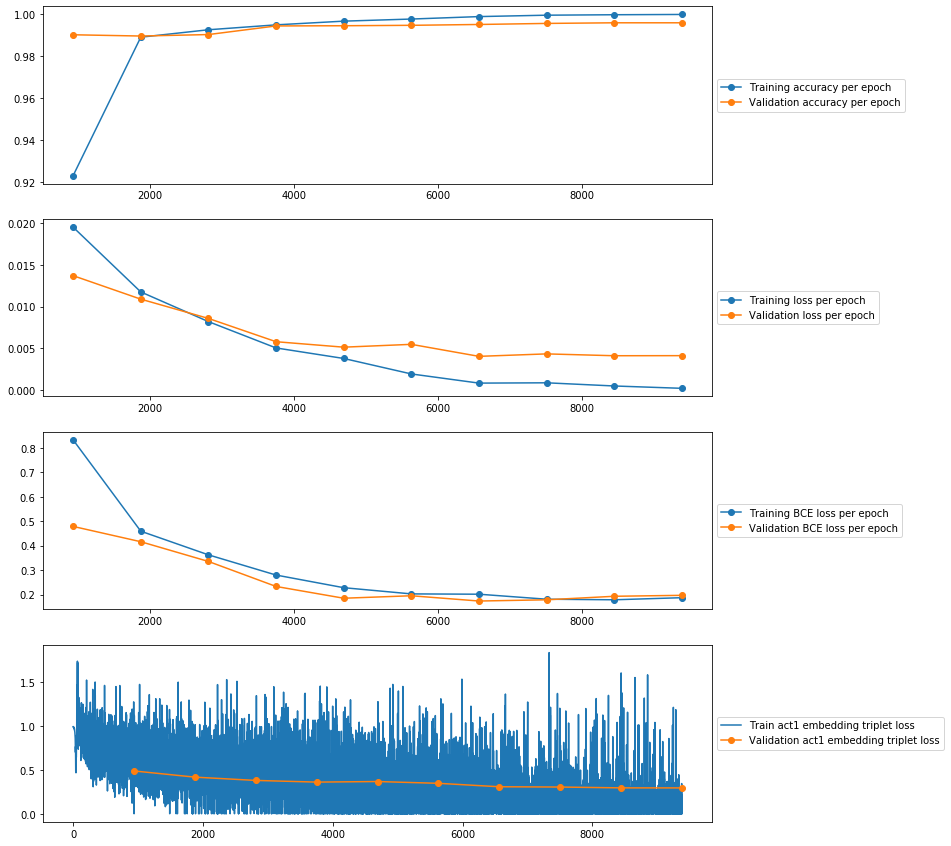

In [15]:
validator2.plot()

In [16]:
np.max(validator2.val_accuracies), "Best accuracy with reg"

(0.9957, 'Best accuracy with reg')

In [17]:
np.max(validator.val_accuracies), "Best accuracy without reg"

(0.9855, 'Best accuracy without reg')

In [ ]:
def tensorboard_embeddings(model, select, board):
    old_select = model._to_select
    model._to_select = select.
    writer = SummaryWriter()